In [36]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import cv2
import tqdm

In [48]:
#invert binary arrays
def invert_binary(img):
    for i in range(0, len(img)):
        for j in range(0, len(img[i])):
            if img[i][j] == 1:
                img[i][j] = 0
            else:
                img[i][j] = 1
    return img

#resize image
def resize(img):
    rows = []
    for i in range(0,len(img)):
        c = 0
        for j in range(0,len(img[i])):
            if img[i][j] == 1:
                c=+1
                break
        if c == 0:
            rows.append(i)
    if len(rows) > 0:
        img = np.delete(img, rows, axis=0)

    #Delete empty columns
    rows = []
    img = img.T
    for i in range(0,len(img)):
        c = 0
        for j in range(0,len(img[i])):
            if img[i][j] == 1:
                c=+1
                break
        if c == 0:
            rows.append(i)
    if len(rows) > 0:
        img = np.delete(img, rows, axis=0)
    img = img.T

    #Resize image
    resized_img = cv2.resize(img, (8, 8))

    every = 0
    for i in range(0, len(resized_img)):
        for j in range(0, len(resized_img[i])):
            every += resized_img[i][j]
            resized_img[i][j] = round(resized_img[i][j], 1)
    median = every/(8*8)

    #print(resized_img, "\n", median)

    for i in range(0, len(resized_img)):
        for j in range(0, len(resized_img[i])):
            if resized_img[i][j] >= round(median,2):
                resized_img[i][j] = 1
            else:
                resized_img[i][j] = 0


    #plt.imshow(resized_img, cmap="gray")
    #plt.show()
    return resized_img

#calculate mass center using binary values
def calc_binary_centroid(img):
    coords_x = []
    coords_y = []
    for x in range(0, len(img)):
        for y in range(0, len(img)):
            if img[y][x] > 0:
                coords_x.append(x)
                coords_y.append(y)
    x = np.asarray(coords_x, dtype=np.dtype("float32"))
    y = np.asarray(coords_y, dtype=np.dtype("float32"))
    return x.mean(), y.mean()

#calculate mass center using decimal values
def calc_decimal_centroid(img):
    x_decimal = []
    for i in range(0, len(img)):
        x = 0
        x += img[i][0]*128
        x += img[i][1]*64
        x += img[i][2]*32
        x += img[i][3]*16
        x += img[i][4]*8
        x += img[i][5]*4
        x += img[i][6]*2
        x += img[i][7]*1
        x_decimal.append(x)

    b = 0
    for i in x_decimal:
        b+=i
    x_avg = b/len(x_decimal)
    
    y_decimal = []    
    for i in range(0, len(img)):
        y = 0
        y += img[0][i]*128
        y += img[1][i]*64
        y += img[2][i]*32
        y += img[3][i]*16
        y += img[4][i]*8
        y += img[5][i]*4
        y += img[6][i]*2
        y += img[7][i]*1
        y_decimal.append(y)
        
    b = 0
    for i in y_decimal:
        b+=i
    y_avg = b/len(y_decimal)
    
    return x_avg, y_avg


#euclidean distance
def distance(x,y, x1,y1):
    return np.sqrt((x1-x)**2 + (y1-y)**2)

#calculate cluster center based on several samples extracted directly from folder, using either decimal or binary values
def map_centers(folder, mode="decimal"):
    numbers = {}
    centers = {}
    for alg in os.listdir(folder):
        numbers[int(alg)] = []
        for image in os.listdir("%s/%s/"%(folder, alg)):
            img = plt.imread("%s/%s/%s"%(folder,alg, image))
            img = invert_binary(img)
            img = resize(img)
            if mode == "binary":
                numbers[int(alg)].append(calc_binary_centroid(img))
            elif mode == "decimal":
                numbers[int(alg)].append(calc_decimal_centroid(img))
            else:
                print("invalid mode")
                return False
            
    for number in numbers:
        all_x = []
        all_y = []
        for coord in numbers[number]:
            all_x.append(coord[0])
            all_y.append(coord[1])
        all_x = np.asarray(all_x, dtype=np.dtype("float32"))
        all_y = np.asarray(all_y, dtype=np.dtype("float32"))
        mean_x = all_x.mean()
        mean_y = all_y.mean()
        centers[number] = [mean_x, mean_y]

    #plot all sample's mass centers with colors for each label
    c = 0
    colors = cm.rainbow(np.linspace(0, 1, len(numbers.keys())))
    for number in numbers.keys():
        lc = 0
        for coord in numbers[number]:
            if lc == 0:
                plt.scatter(coord[0], coord[1], color=colors[c], label="%s"%number)
                lc+=1
            else:
                plt.scatter(coord[0], coord[1], color=colors[c])
        c+=1
    for number in centers:
        print(number)
        plt.scatter(centers[number][0],centers[number][1], label="center of %s"%number)
    plt.legend()
    plt.show()
    return numbers, centers

def classify(x, y, centers, label=False):
    smallest_dist = [None,None]
    for center in centers:
        dist = distance(x,y, centers[center][0],centers[center][1])
        if smallest_dist == [None,None]:
            smallest_dist = [center, dist]
        elif dist < smallest_dist[1]:
            smallest_dist = [center, dist]
    if label != False:
        if label == smallest_dist[0]:
            return (True, smallest_dist[0], smallest_dist[1])
        else:
            return(False, smallest_dist[0], smallest_dist[1])
    else:
        print(smallest_dist)

In [74]:
new_label = [8, 24, 24, 8, 8, 8, 8, 8]

4
5
6
7
8
9


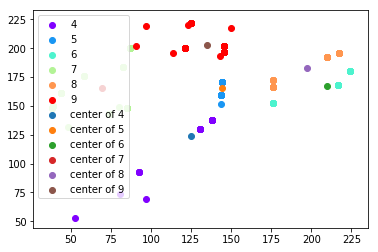

In [50]:
numbers, centers = map_centers("./train/", mode="decimal")

4
5
6
7
8
9


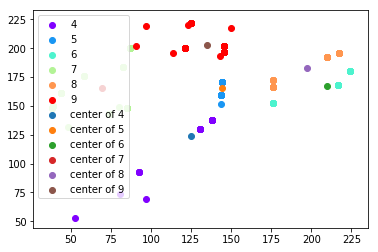

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.18it/s]


validation accuracy = 0.97


In [51]:
#Maping clusters
numbers, centers = map_centers("./train/", mode="decimal")

#Classifying with accuracy validation
total_evaluated = 0

missed = []
correct = []

for label in tqdm.tqdm(os.listdir("./train/")):
    for sample in os.listdir("./train/%s"%label):
        if int(label) in centers:
            img = plt.imread("./train/%s/%s"%(label,sample))
            img = invert_binary(img)
            img = resize(img)
            img_mass_center_x, img_mass_center_y = calc_decimal_centroid(img)
            predicted = classify(img_mass_center_x, img_mass_center_y, centers, label=int(label))
            if predicted[0] == True:
                correct.append([predicted[1], predicted[2]])
            else:
                missed.append([predicted[1], predicted[2]])
            #plt.imshow(img, cmap="gray")
            #plt.show()
            #print(predicted)
            total_evaluated +=1 
        else:
            pass

#Calculate accuracy
print("validation accuracy = %s"%(round(len(correct)/total_evaluated, 3)))

In [11]:
rows = []
for i in range(0,len(img)):
    c = 0
    for j in range(0,len(img[i])):
        if img[i][j] == 1:
            c=+1
            break
    if c == 0:
        rows.append(i)
if len(rows) > 0:
    img = np.delete(img, rows, axis=0)

#Delete empty columns
rows = []
img = img.T
for i in range(0,len(img)):
    c = 0
    for j in range(0,len(img[i])):
        if img[i][j] == 1:
            c=+1
            break
    if c == 0:
        rows.append(i)
if len(rows) > 0:
    img = np.delete(img, rows, axis=0)
img = img.T

#Resize image
resized_img = cv2.resize(img, (8, 8))

every = 0
for i in range(0, len(resized_img)):
    for j in range(0, len(resized_img[i])):
        every += resized_img[i][j]
median = every/(8*8)

for i in range(0, len(resized_img)):
    for j in range(0, len(resized_img[i])):
        if resized_img[i][j] > median:
            resized_img[i][j] = 1
        else:
            resized_img[i][j] = 0

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]] 
 0.28125


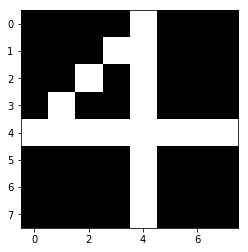

[[1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]] 
 0.28125


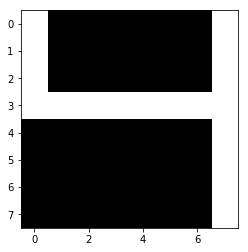

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


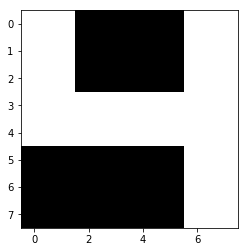

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


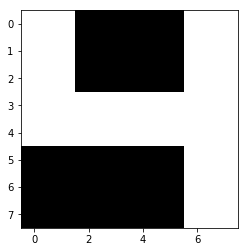

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


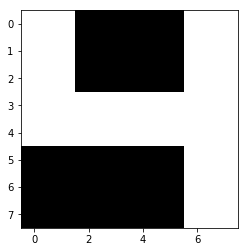

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


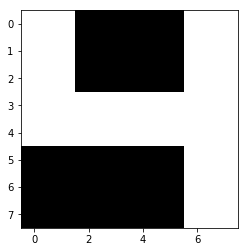

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


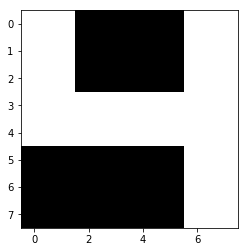

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


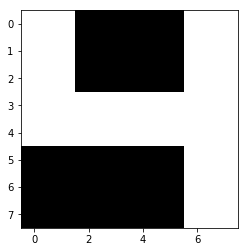

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


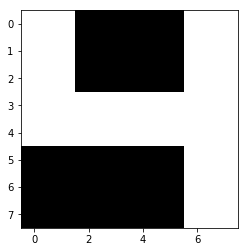

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


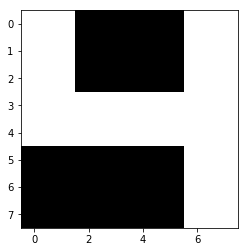

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


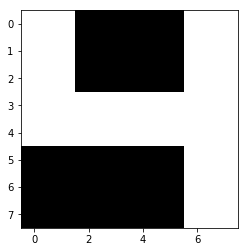

[[0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.5 0.9 0.7 0.  0. ]
 [0.  0.  0.5 0.5 0.6 0.7 0.  0. ]
 [0.  0.5 0.5 0.2 0.4 0.7 0.  0. ]
 [0.4 0.9 0.6 0.4 0.7 0.8 0.4 0.4]
 [0.7 0.7 0.7 0.7 0.8 0.9 0.7 0.7]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]] 
 0.32080078125


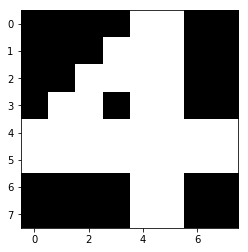

[[1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.462890625


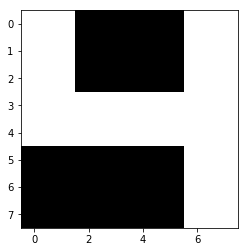

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3935546875


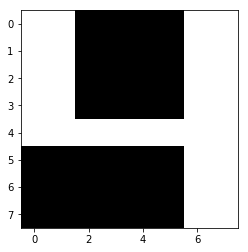

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3935546875


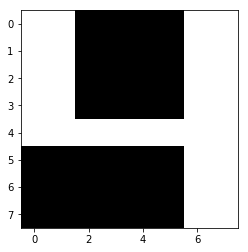

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3935546875


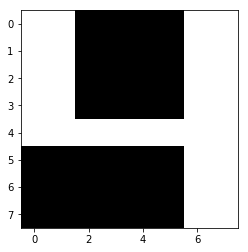

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3935546875


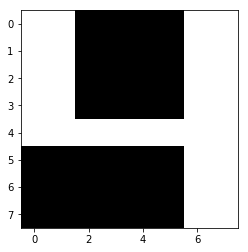

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


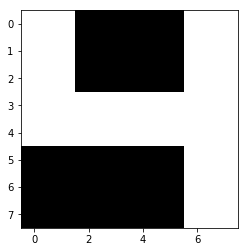

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


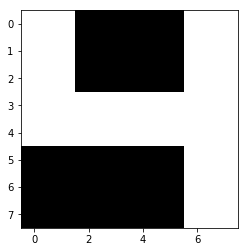

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


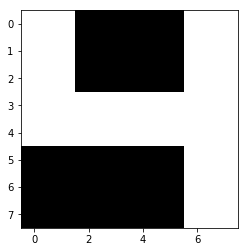

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


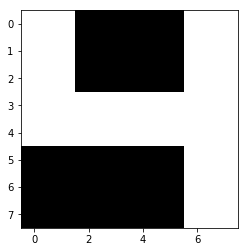

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


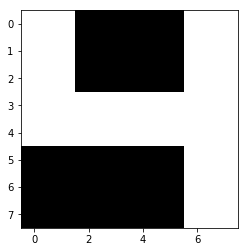

[[0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.5 0.9 0.7 0.  0. ]
 [0.  0.  0.5 0.5 0.6 0.7 0.  0. ]
 [0.  0.5 0.5 0.2 0.4 0.7 0.  0. ]
 [0.4 0.9 0.6 0.4 0.7 0.8 0.4 0.4]
 [0.7 0.7 0.7 0.7 0.8 0.9 0.7 0.7]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]] 
 0.32080078125


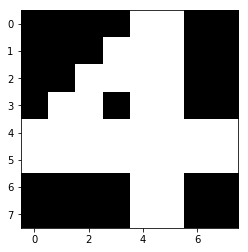

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


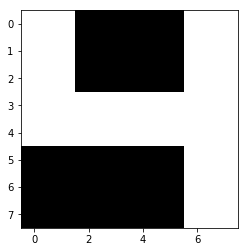

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


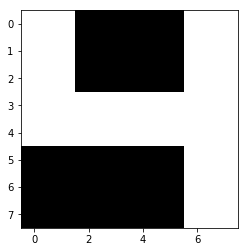

[[1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.8 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.39239501953125


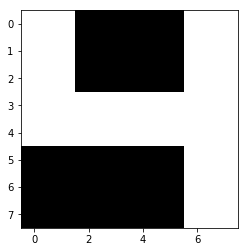

[[0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.5 0.9 0.7 0.  0. ]
 [0.  0.  0.5 0.5 0.6 0.7 0.  0. ]
 [0.  0.5 0.5 0.2 0.4 0.7 0.  0. ]
 [0.4 0.9 0.6 0.4 0.7 0.8 0.4 0.4]
 [0.7 0.7 0.7 0.7 0.8 0.9 0.7 0.7]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]] 
 0.32080078125


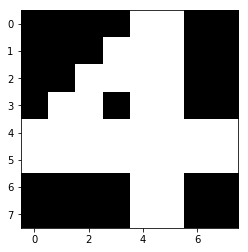

[[0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.5 0.9 0.7 0.  0. ]
 [0.  0.  0.5 0.5 0.6 0.7 0.  0. ]
 [0.  0.5 0.5 0.2 0.4 0.7 0.  0. ]
 [0.4 0.9 0.6 0.4 0.7 0.8 0.4 0.4]
 [0.7 0.7 0.7 0.7 0.8 0.9 0.7 0.7]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]] 
 0.32080078125


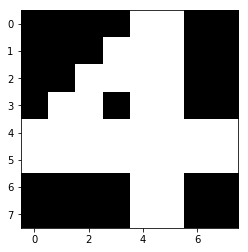

[[1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]] 
 0.361328125


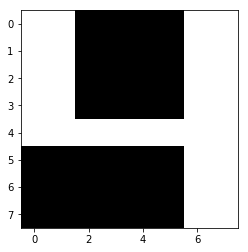

[[1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]] 
 0.361328125


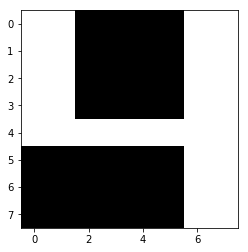

[[1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]] 
 0.361328125


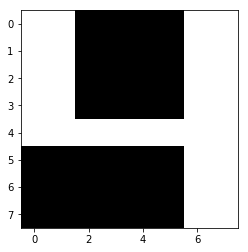

[[1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]] 
 0.296875


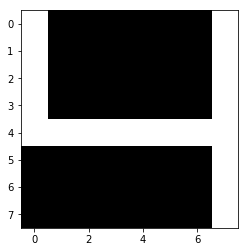

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]] 
 0.453125


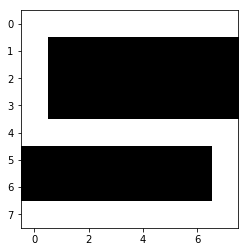

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.3 1. ]
 [0.6 0.1 0.  0.  0.  0.  0.2 1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.5 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6107177734375


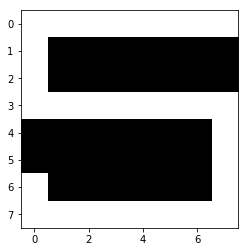

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


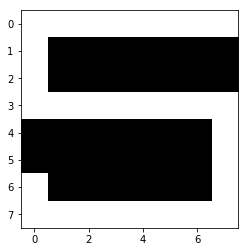

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


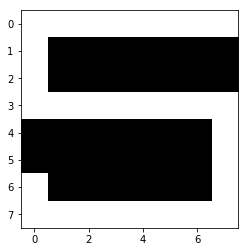

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


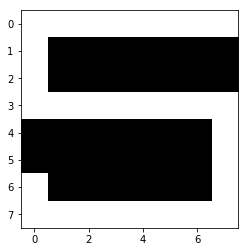

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


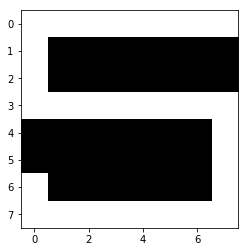

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


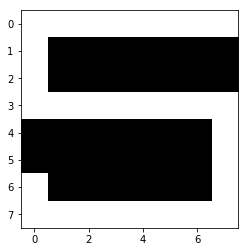

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


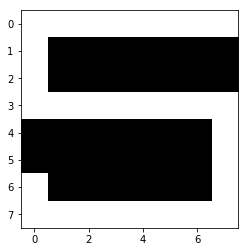

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


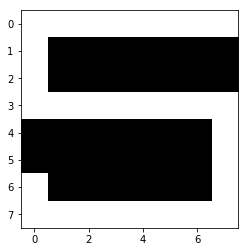

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


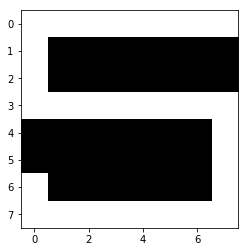

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.6 0.2 0.  0.  0.  0.  0.4 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.625732421875


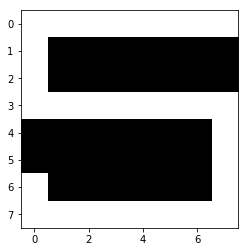

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]] 
 0.46875


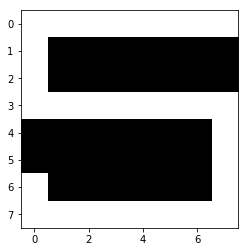

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


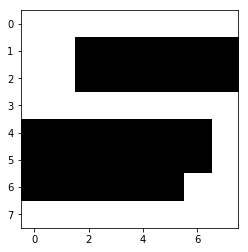

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


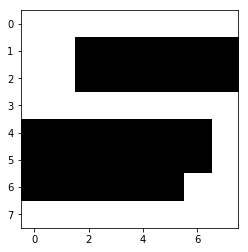

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


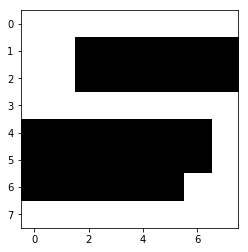

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


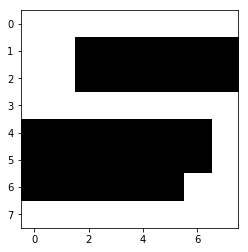

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


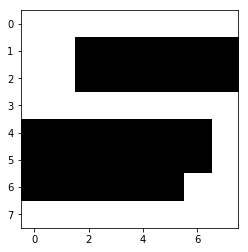

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


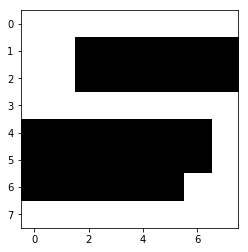

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


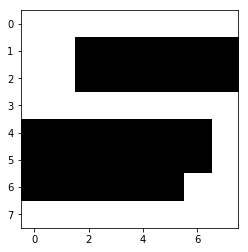

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


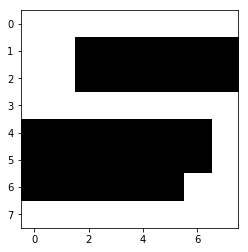

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.6 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.5 1. ]
 [0.  0.  0.  0.  0.  0.  0.4 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.598876953125


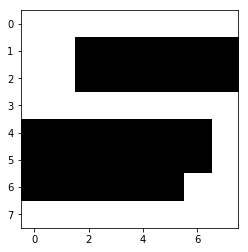

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


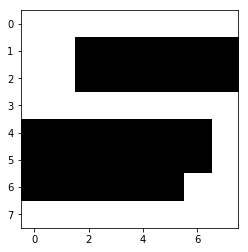

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.2 1. ]
 [0.  0.  0.  0.  0.  0.  0.2 1. ]
 [1.  0.2 0.  0.  0.  0.  0.2 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.486328125


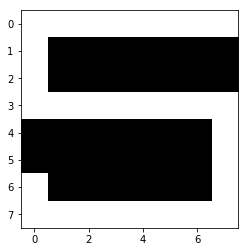

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


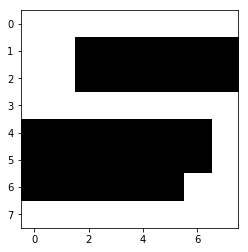

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


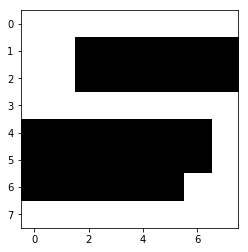

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


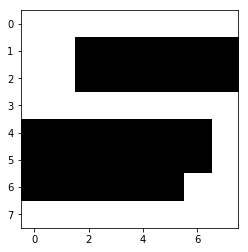

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


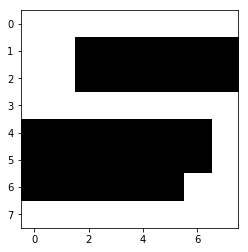

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


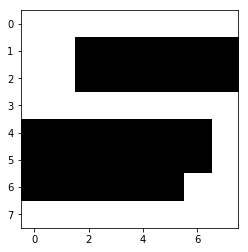

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


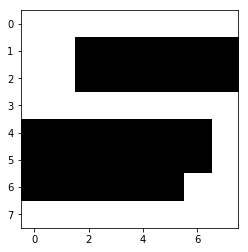

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


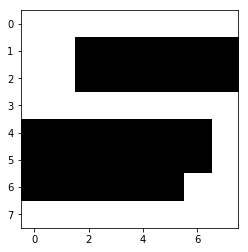

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


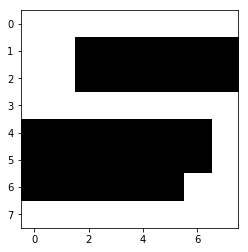

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


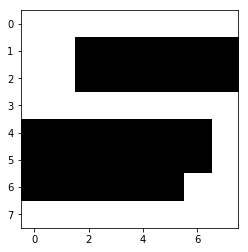

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


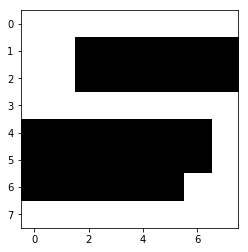

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.2 1. ]
 [0.  0.  0.  0.  0.  0.  0.2 1. ]
 [1.  0.2 0.  0.  0.  0.  0.2 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.486328125


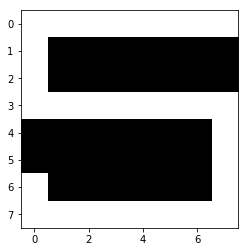

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.7 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.7 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6102294921875


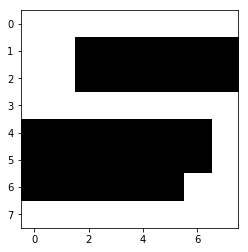

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.3 1. ]
 [0.6 0.1 0.  0.  0.  0.  0.2 1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.5 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6107177734375


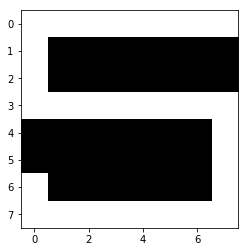

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.3 1. ]
 [0.6 0.1 0.  0.  0.  0.  0.2 1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.5 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6107177734375


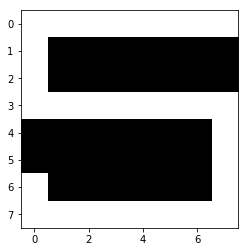

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.3 1. ]
 [0.6 0.1 0.  0.  0.  0.  0.2 1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.5 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6107177734375


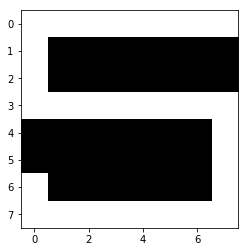

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.3 1. ]
 [0.6 0.1 0.  0.  0.  0.  0.2 1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.5 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6107177734375


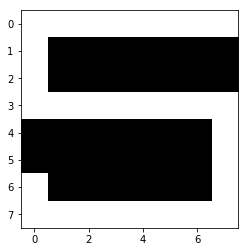

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [1.  0.5 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.3 1. ]
 [0.6 0.1 0.  0.  0.  0.  0.2 1. ]
 [1.  0.5 0.4 0.4 0.4 0.4 0.5 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6107177734375


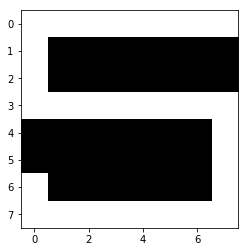

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.5458984375


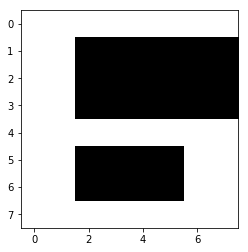

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


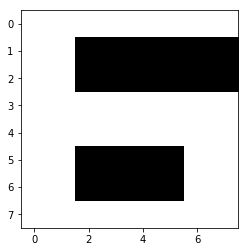

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


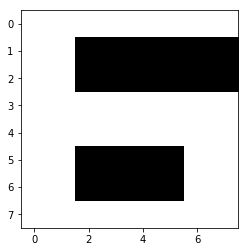

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


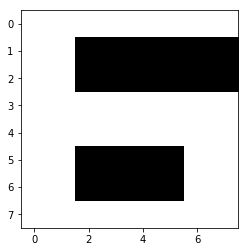

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


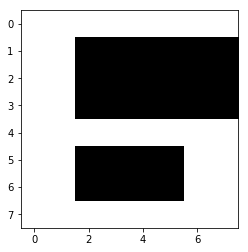

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


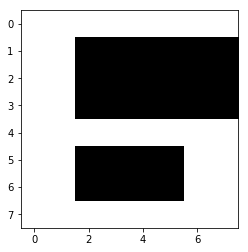

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


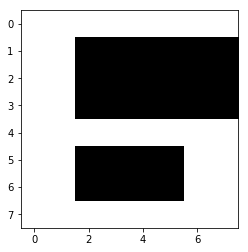

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


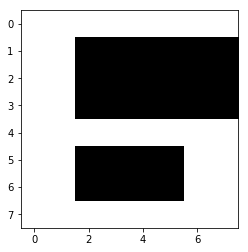

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


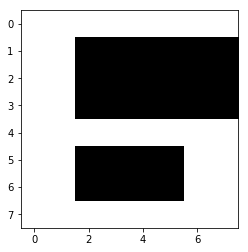

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


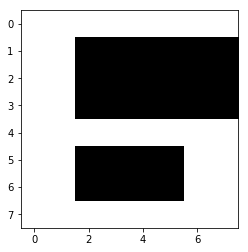

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


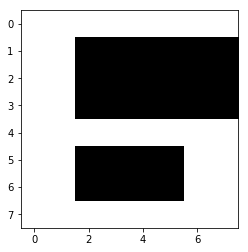

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.5458984375


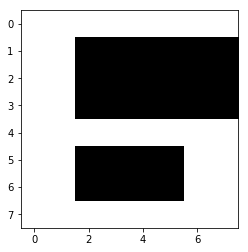

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


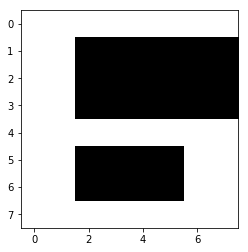

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


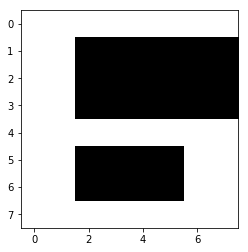

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


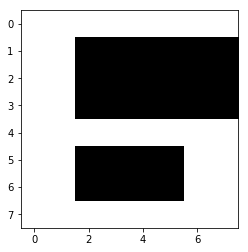

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


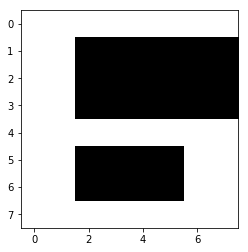

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


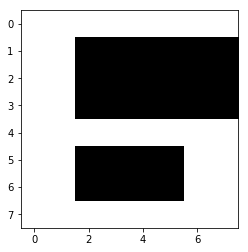

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


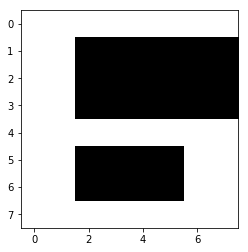

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


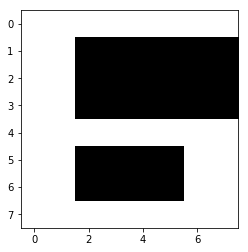

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.4 0.4 0.4]
 [1.  0.8 0.2 0.  0.  0.  0.  0. ]
 [1.  0.8 0.3 0.1 0.1 0.1 0.1 0.1]
 [1.  1.  0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.67578125


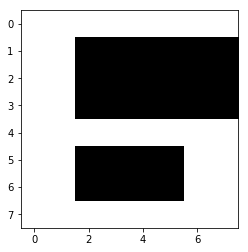

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]] 
 0.484375


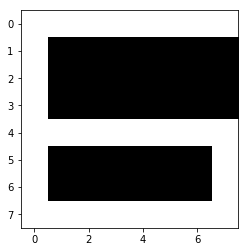

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]] 
 0.484375


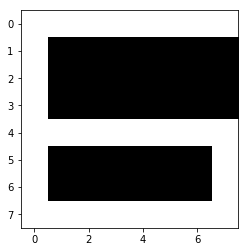

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.5458984375


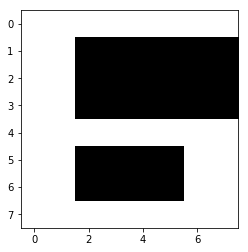

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.2 0.  0.  0.  0.  0.2 1. ]
 [1.  0.2 0.  0.  0.  0.  0.2 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.5048828125


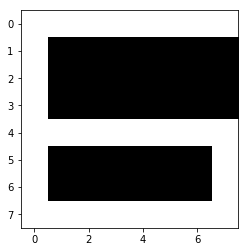

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  0.2 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.2 0.  0.  0.  0.  0.2 1. ]
 [1.  0.2 0.  0.  0.  0.  0.2 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.5048828125


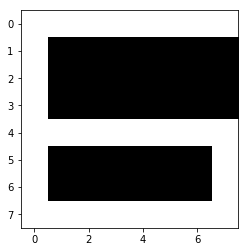

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.525390625


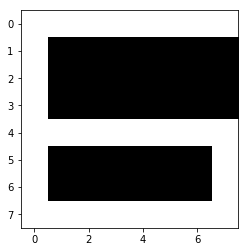

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.525390625


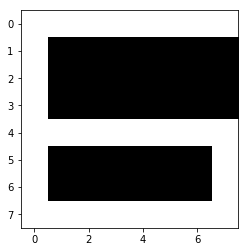

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.525390625


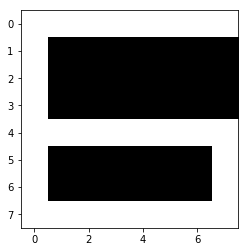

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.5458984375


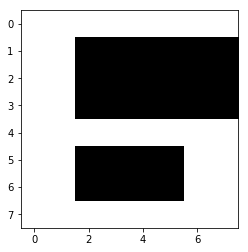

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


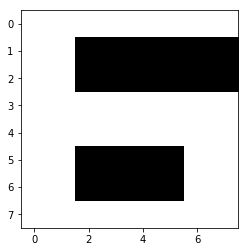

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


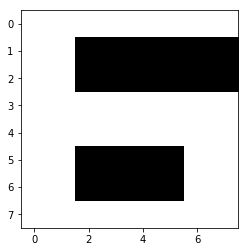

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


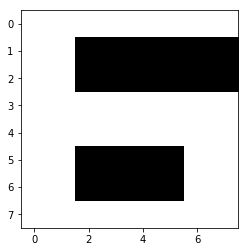

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


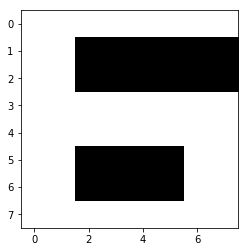

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.2 0.2]
 [1.  0.6 0.  0.  0.  0.  0.  0. ]
 [1.  0.8 0.6 0.6 0.6 0.6 0.6 0.6]
 [1.  0.8 0.6 0.6 0.6 0.6 0.8 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.2 0.2 0.2 0.2 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.602294921875


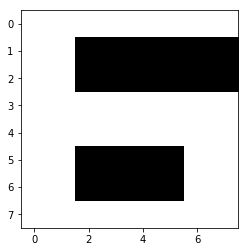

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.9 1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.283203125


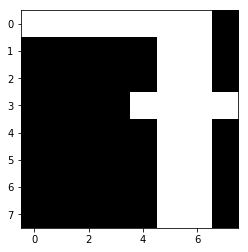

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


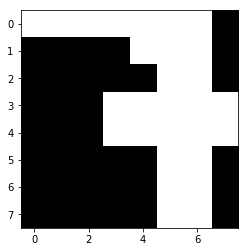

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


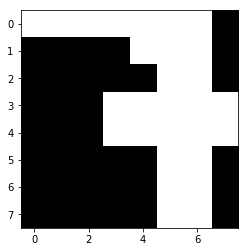

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


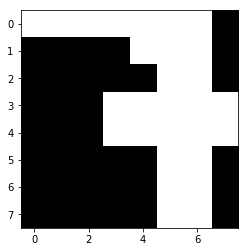

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


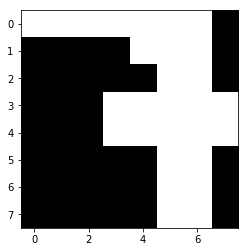

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


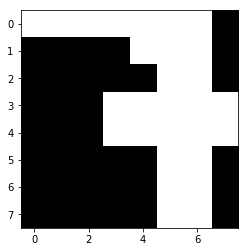

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


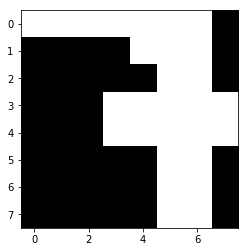

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


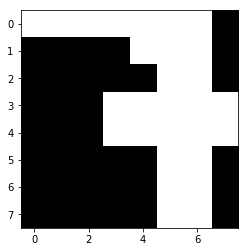

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [0.2 0.2 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.4 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.3529052734375


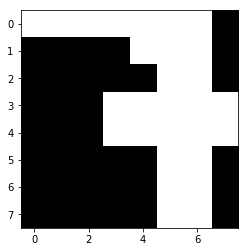

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


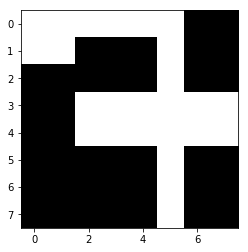

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


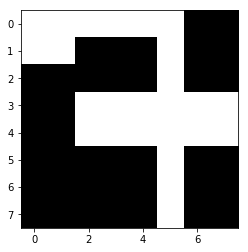

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.9 1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.283203125


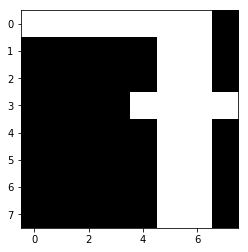

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


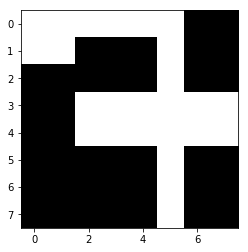

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


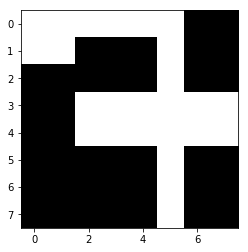

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


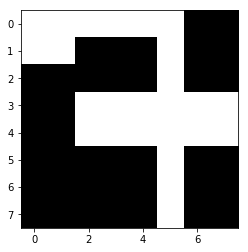

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


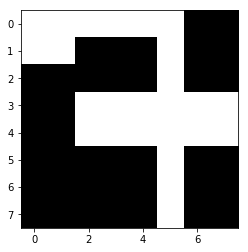

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


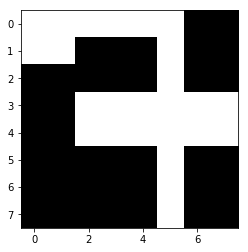

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.6 0.2 0.2 0.4 0.9 0.4 0. ]
 [0.3 0.2 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.2 0.6 0.6 0.7 1.  0.8 0.6]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.4100341796875


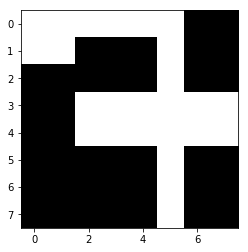

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


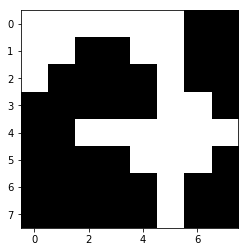

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


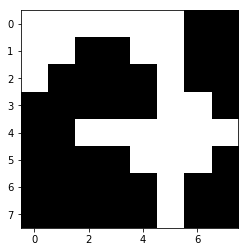

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


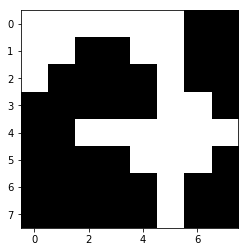

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.9 1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.283203125


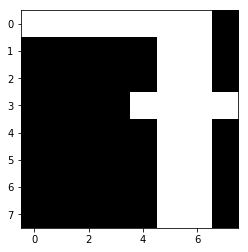

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


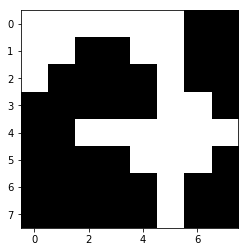

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


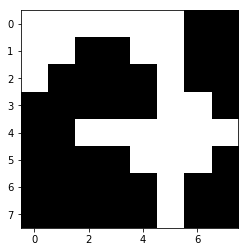

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


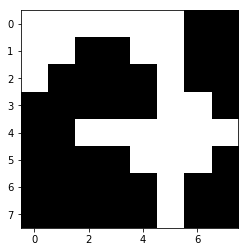

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


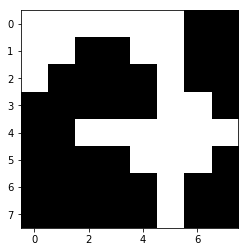

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


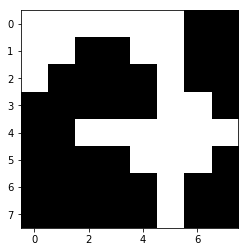

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


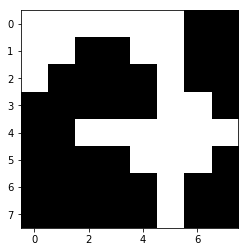

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


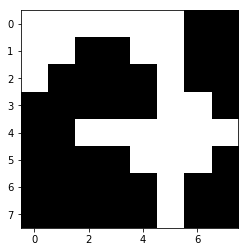

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


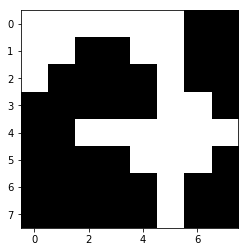

[[1.  1.  1.  1.  1.  1.  0.4 0. ]
 [1.  0.7 0.4 0.4 0.6 1.  0.4 0. ]
 [0.6 0.4 0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.1 0.1 0.1 0.4 0.9 0.5 0.1]
 [0.  0.4 0.9 0.9 0.9 1.  0.9 0.9]
 [0.  0.2 0.4 0.4 0.6 1.  0.6 0.4]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]
 [0.  0.  0.  0.  0.3 0.9 0.4 0. ]] 
 0.445556640625


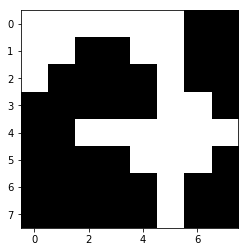

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3203125


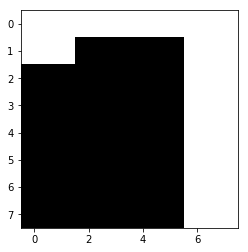

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.2 0.2 0.2 0.2 0.2 0.7 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.3043212890625


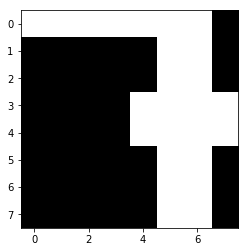

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3203125


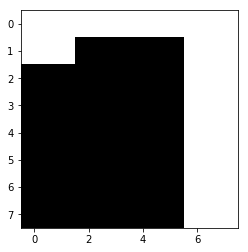

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3203125


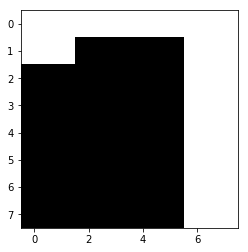

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3203125


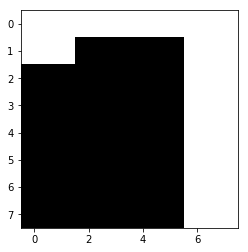

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3447265625


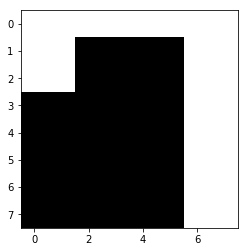

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3447265625


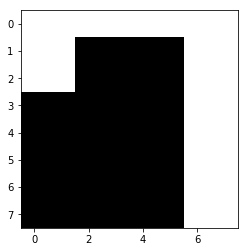

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3447265625


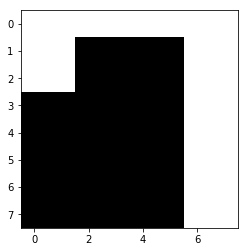

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]
 [0.  0.  0.  0.  0.  0.  0.6 1. ]] 
 0.3447265625


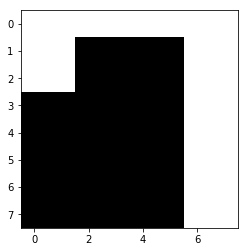

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


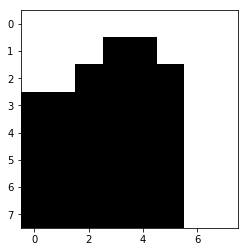

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


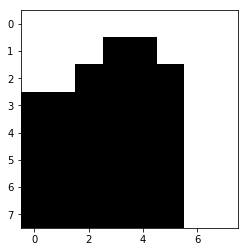

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


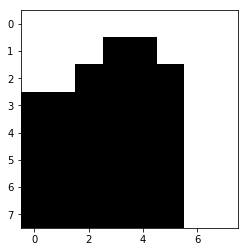

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.2 0.2 0.2 0.2 0.2 0.7 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.3043212890625


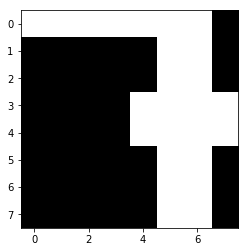

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


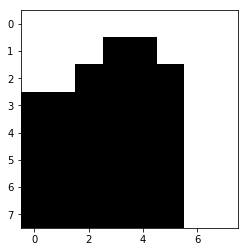

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


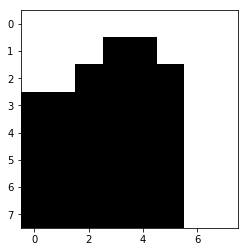

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


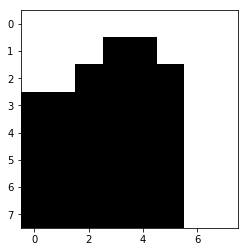

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


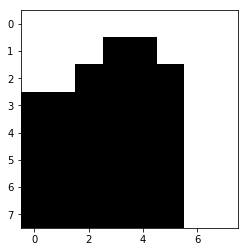

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


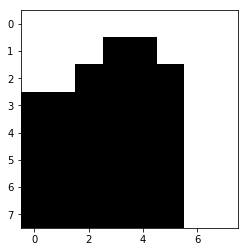

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


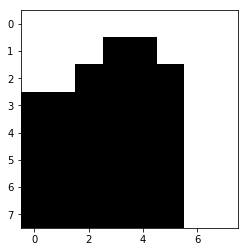

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


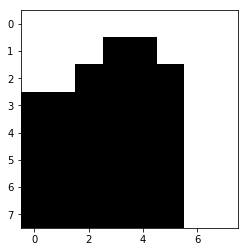

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


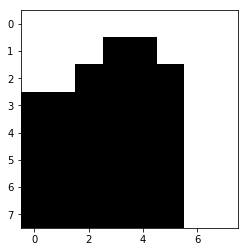

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


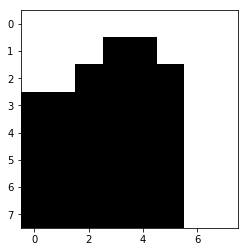

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.2 0.2 0.2 0.2 0.2 0.7 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.3043212890625


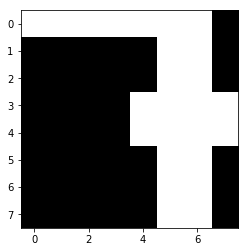

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


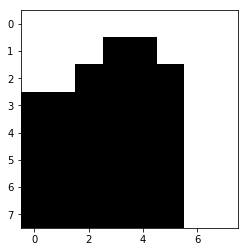

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


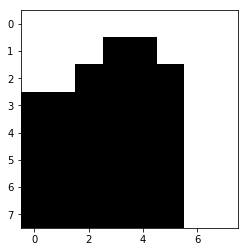

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.5 0.4 0.4 0.5 0.8 1. ]
 [0.6 0.5 0.2 0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.41796875


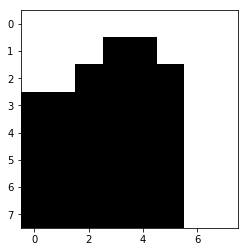

[[1.  1.  1.  1.  1.  0.4 0.  0. ]
 [1.  0.4 0.  0.1 0.9 0.4 0.  0. ]
 [0.  0.  0.  0.1 0.9 0.4 0.  0. ]
 [0.  0.  0.  0.1 0.9 0.4 0.  0. ]
 [0.  0.6 1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.1 0.9 0.4 0.  0. ]
 [0.  0.  0.  0.1 0.9 0.4 0.  0. ]
 [0.  0.  0.  0.1 0.9 0.4 0.  0. ]] 
 0.337890625


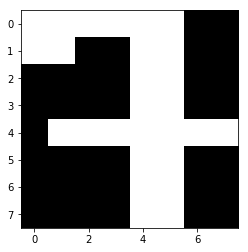

[[1.  1.  1.  1.  1.  0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.7 1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]
 [0.  0.  0.  0.  0.4 0.7 0.  0. ]] 
 0.283203125


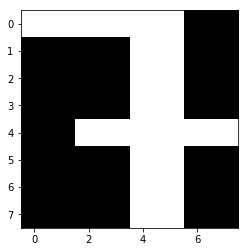

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.2 0.2 0.2 0.2 0.2 0.7 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.3043212890625


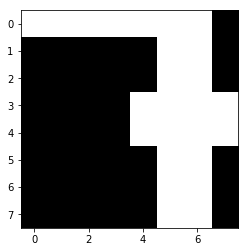

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.2 0.2 0.2 0.2 0.2 0.7 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.3043212890625


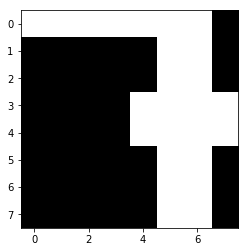

[[1.  1.  1.  1.  1.  1.  0.6 0. ]
 [0.2 0.2 0.2 0.2 0.2 0.7 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.1 0.5 0.8 0.8 0.6]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0.6 0. ]] 
 0.3043212890625


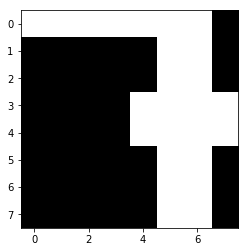

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


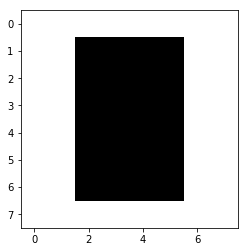

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


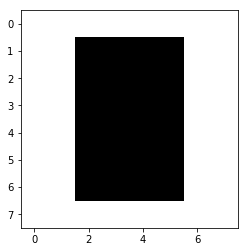

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


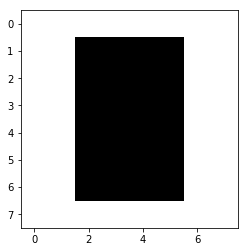

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


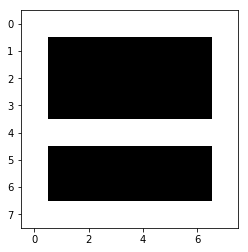

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


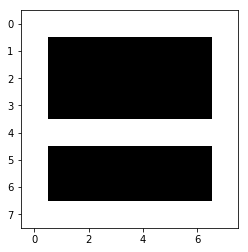

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


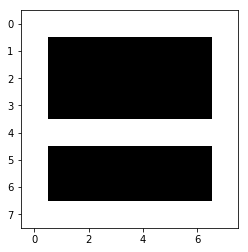

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


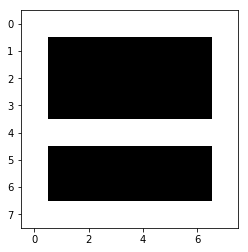

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


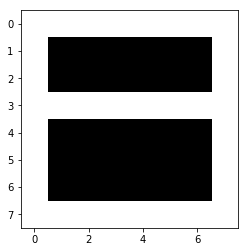

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


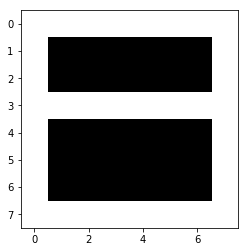

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


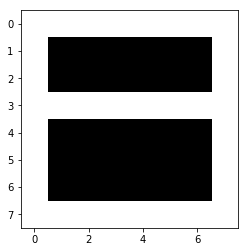

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  0.6 0.  0.  0.  0.  0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.619140625


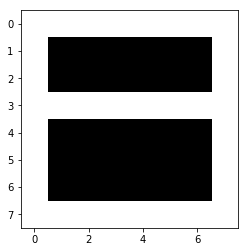

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


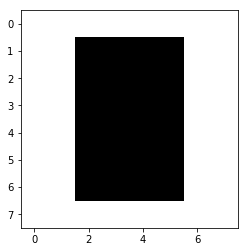

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


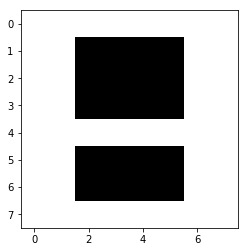

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


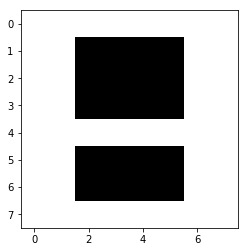

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


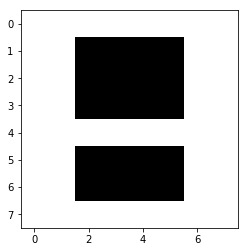

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


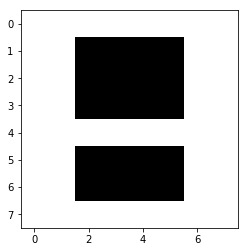

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


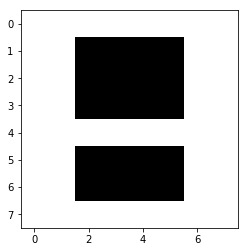

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


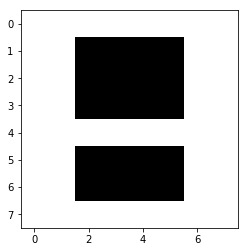

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


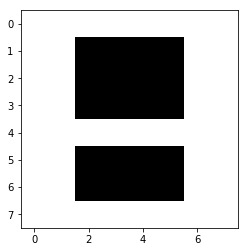

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


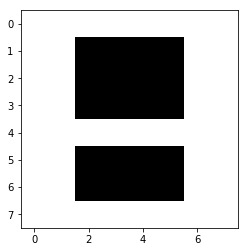

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


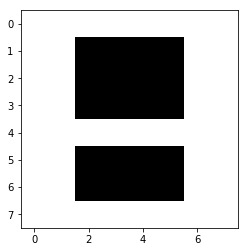

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


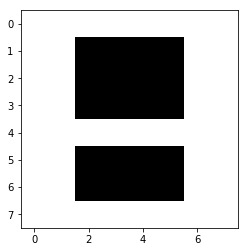

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


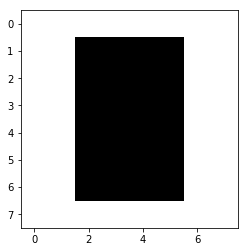

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


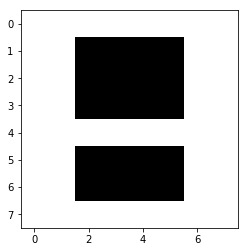

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


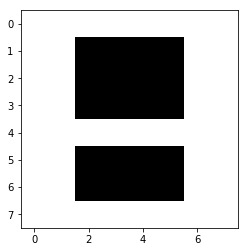

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.9 0.9 0.9 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.841064453125


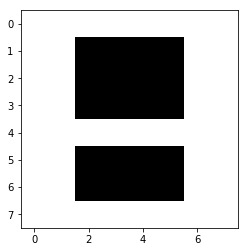

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


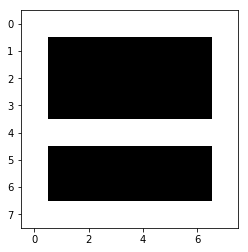

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


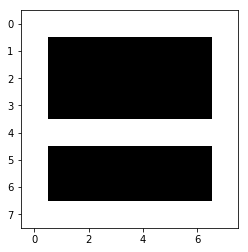

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


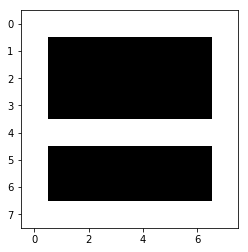

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


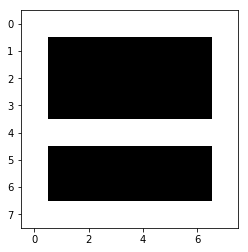

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


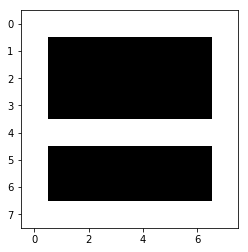

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


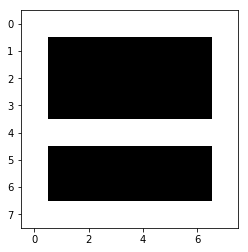

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


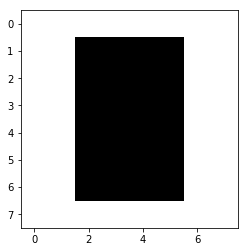

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


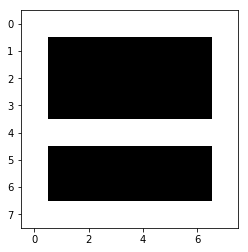

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


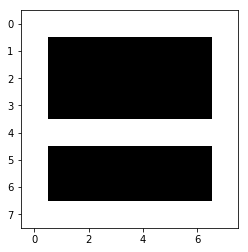

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.4 0.  0.  0.  0.  0.4 1. ]
 [1.  0.5 0.1 0.1 0.1 0.1 0.5 1. ]
 [1.  0.9 0.9 0.9 0.9 0.9 0.9 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  0.6 0.4 0.4 0.4 0.4 0.6 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.68212890625


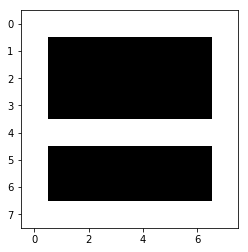

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]] 
 0.53125


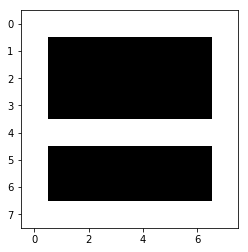

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]] 
 0.53125


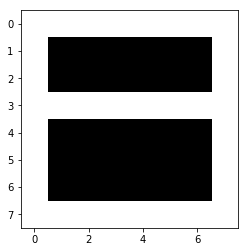

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


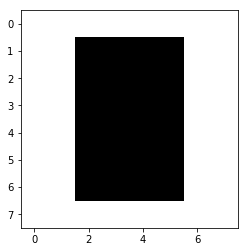

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


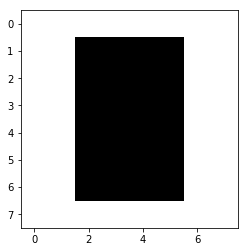

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


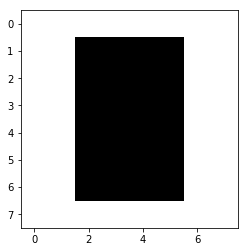

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


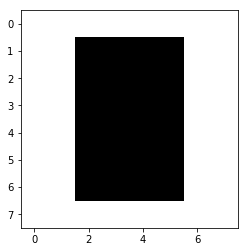

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.71875


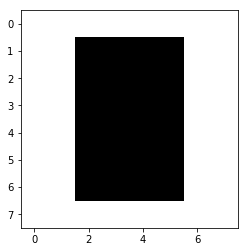

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


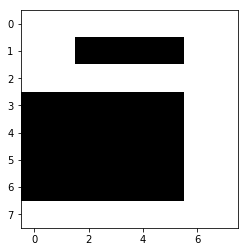

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


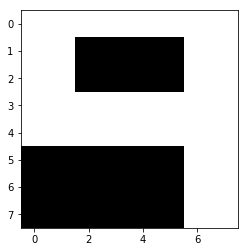

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


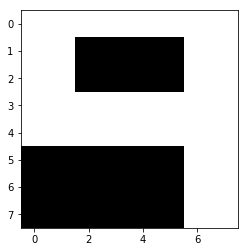

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


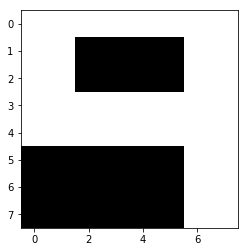

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


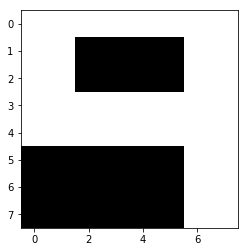

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


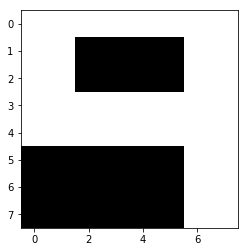

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


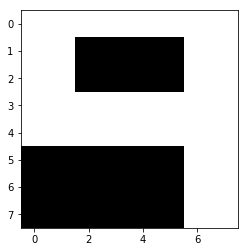

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


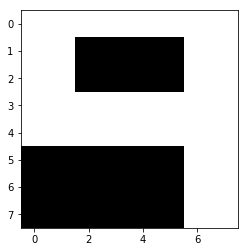

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


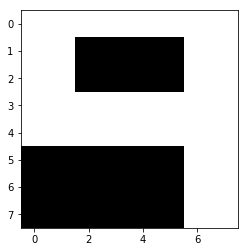

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


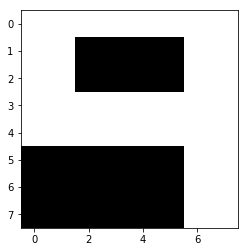

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


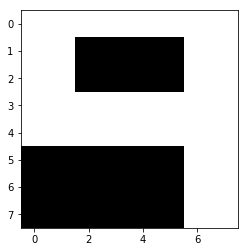

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.59375


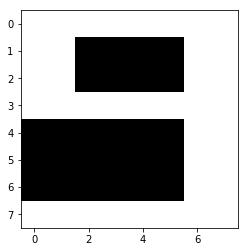

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


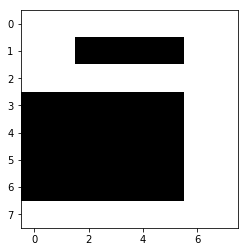

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


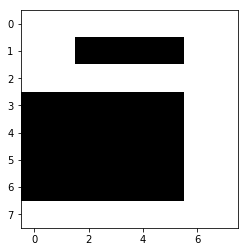

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


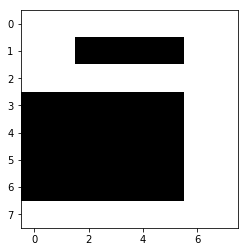

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


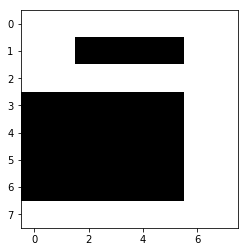

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


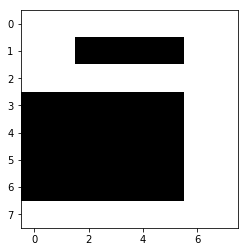

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


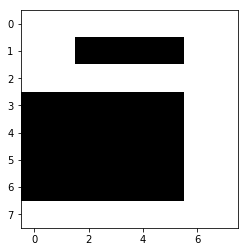

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


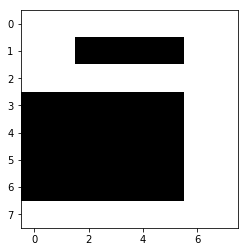

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


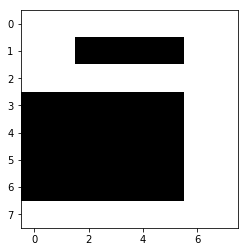

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


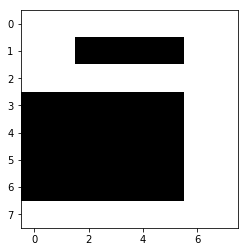

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.61328125


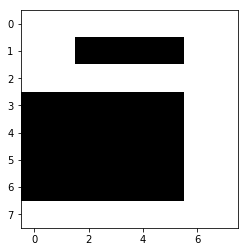

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


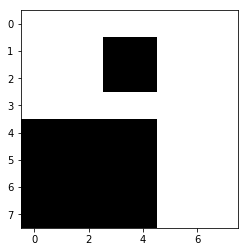

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


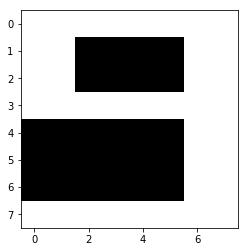

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


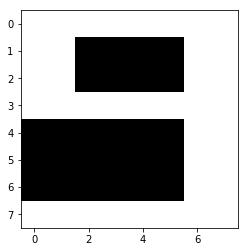

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


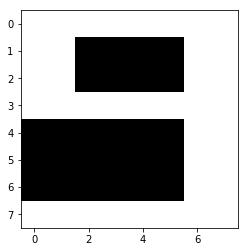

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


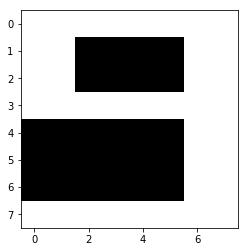

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


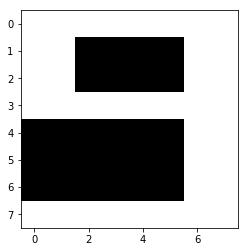

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


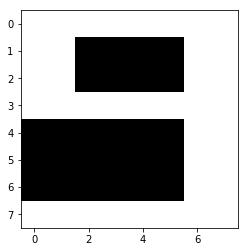

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


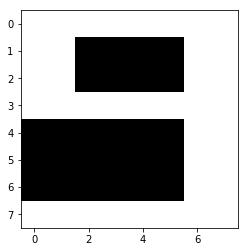

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


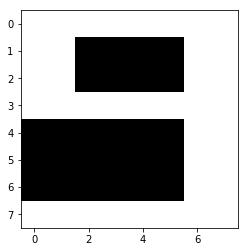

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


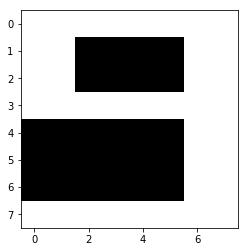

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


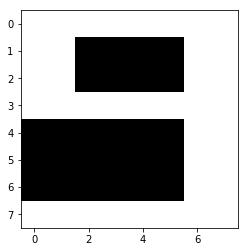

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.3 0.3 0.6 0.9 1. ]
 [1.  1.  0.9 0.7 0.7 0.9 1.  1. ]
 [0.4 0.4 0.4 0.4 0.5 0.8 1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.57513427734375


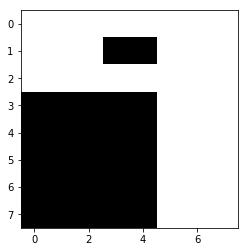

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


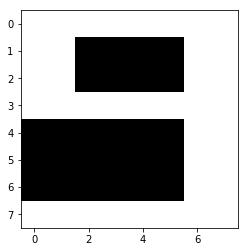

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


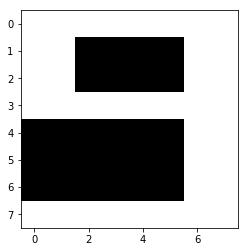

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


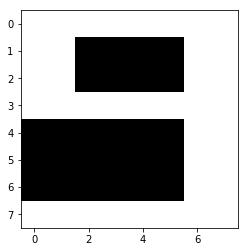

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


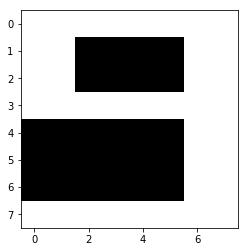

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


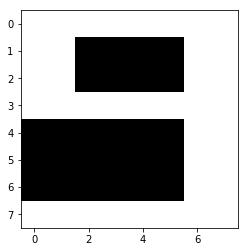

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


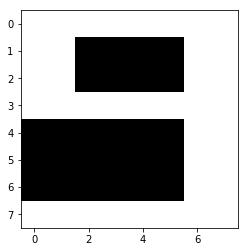

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


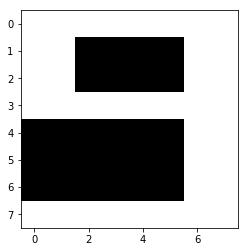

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.5 0.7 1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.7308349609375


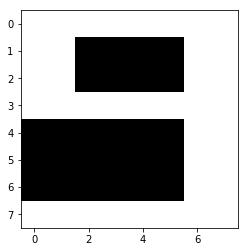

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


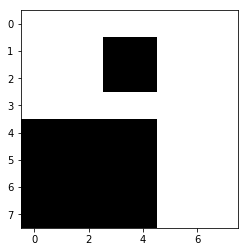

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


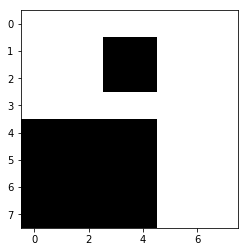

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [1.  1.  0.7 0.5 0.5 0.7 1.  1. ]
 [0.9 0.9 0.9 0.9 0.9 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.3 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.61669921875


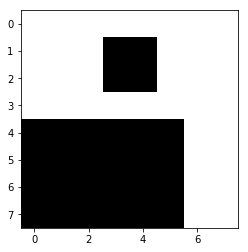

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


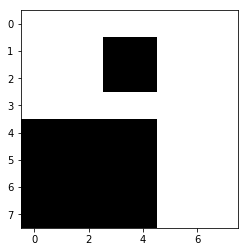

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


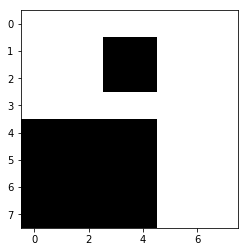

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


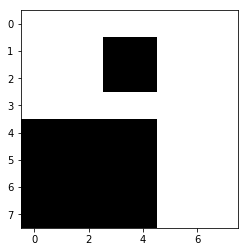

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.5859375


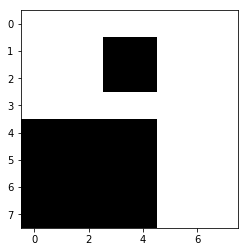

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.2 0.2 0.2 0.2 0.2 0.4 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]] 
 0.6484375


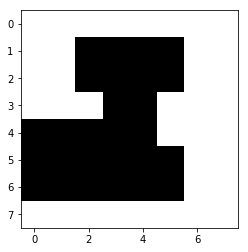

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.8 0.6 0.6 0.8 1.  1. ]
 [1.  0.9 0.6 0.2 0.2 0.6 0.9 1. ]
 [1.  1.  0.9 0.7 0.7 0.9 1.  1. ]
 [0.7 0.7 0.7 0.7 0.7 0.9 1.  1. ]
 [0.1 0.1 0.1 0.1 0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.2 0.6 0.9 1. ]] 
 0.6610107421875


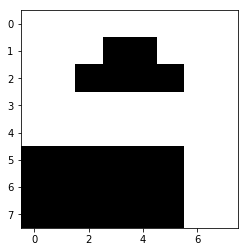

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.9 0.8 0.7 0.7 0.8 0.9 1. ]
 [0.4 0.4 0.4 0.4 0.4 0.6 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.501953125


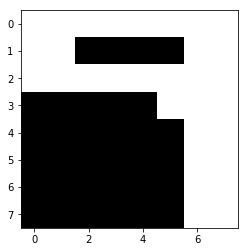

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.4 0.2 0.2 0.4 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.9 0.7 0.6 0.6 0.7 0.9 1. ]
 [0.6 0.6 0.6 0.6 0.6 0.7 0.9 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.537109375


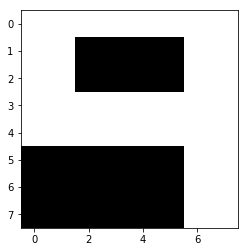

[[1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  0.8 0.2 0.  0.  0.2 0.8 1. ]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]
 [0.  0.  0.  0.  0.  0.2 0.8 1. ]] 
 0.5


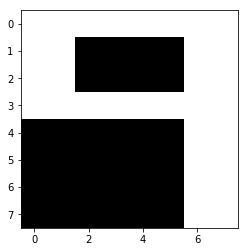

In [59]:
for num in os.listdir("./train/"):
    for image in os.listdir("./train/%s"%num):
        img = plt.imread("./train/%s/%s"%(num, image))
        img = invert_binary(img)


In [77]:
img = plt.imread("./train/4/11.PNG")
plt.imshow(img)
#classify()

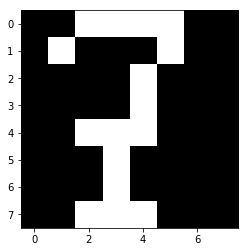

In [41]:
teste = plt.imread("./teste/Sem Título-1.png")
teste = invert_binary(teste)
plt.imshow(teste,cmap="gray")
#resized_test = resize(teste)
x, y = calc_decimal_centroid(resized_test)
#plt.imshow(resized_test)

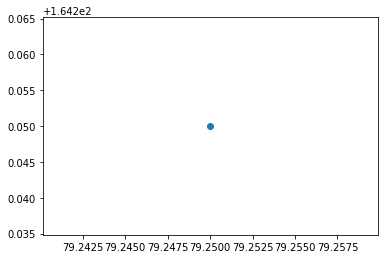

In [42]:
plt.scatter(x,y)

4
5
6
7
8
9


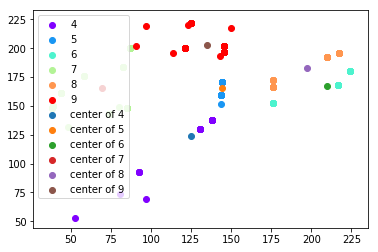

In [25]:
numbers, centers = map_centers("./train/", mode="decimal")

In [30]:
centers

{4: [124.96484, 123.57422],
 5: [144.12813, 165.11874],
 6: [209.88971, 167.63235],
 7: [69.51814, 165.48387],
 8: [197.35464, 182.63954],
 9: [135.07408, 202.9213]}

In [31]:
classify(x,y, centers)

[7, 9.809764792464085]
